In [1]:
# import sys
# !{sys.executable} -m pip install 
# import gdal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import glacierml as gl
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/data/T.csv")


#examine data columns
# dataset.head()

2.5.0


# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [18]:
#drop everything but lat, long, elevation, thickness
raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/data/glac/T_models/T.csv")
dataset = raw_dataset.copy()

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
0,67.91500,18.56800,1.300,NaN,72.0
1,67.91000,18.49600,4.100,NaN,84.0
2,67.90000,18.57000,3.100,NaN,99.0
3,48.35698,-121.05735,2.000,NaN,99.0
4,52.17540,-117.28400,3.800,NaN,150.0
...,...,...,...,...,...
5136,46.20240,-121.49090,NaN,NaN,NaN
5137,46.20240,-121.49090,16.200,NaN,57.0
5138,46.20398,-121.49376,NaN,NaN,NaN
5139,47.08670,12.38000,3.229,NaN,39.0


In [16]:
dataset_saved_for_later = dataset


# dataset = dataset.drop("GLACIER_ID", axis=1)
# dataset = dataset.drop("GlaThiDa_ID", axis=1)
#drop the remaining null pieces from elevation
dataset = dataset.dropna()

#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
# sns.pairplot(train_dataset[["LON","LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [5]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,62.0,49.483826,16.748385,-16.3023,44.722695,45.235790,61.292658,78.87100
LON,62.0,43.460105,55.842181,-134.3600,11.270550,78.176022,79.876970,140.86536
AREA,62.0,5.346357,10.615725,0.0840,1.275000,2.780000,4.142500,71.30000
MEAN_SLOPE,62.0,7.500000,8.634187,0.0000,0.000000,4.000000,13.000000,33.00000
MEAN_THICKNESS,62.0,57.403226,33.228696,4.0000,40.250000,53.000000,67.000000,208.00000


### separate out features - what will be trained to predict desired attribute

In [19]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


## B. Load and Organize the RGI dataset

In [20]:
#split the dataset and reserve some to test what was trained.
# train_dataset = dataset.sample(frac=0.8, random_state=1)
# test_dataset = dataset.drop(train_dataset.index)


RGI = pd.read_csv("/data/fast0/datasets/01_rgi60_Alaska.csv")
RGI

# # RGI = RGI.drop("RGIId", axis=1)
# RGI = RGI.drop("GLIMSId", axis=1)
# RGI = RGI.drop("BgnDate", axis=1)
# RGI = RGI.drop("EndDate", axis=1)
# RGI = RGI.drop("O1Region", axis=1)
# RGI = RGI.drop("O2Region", axis=1)
# RGI = RGI.drop("Zmin", axis=1)
# RGI = RGI.drop("Zmed", axis=1)
# RGI = RGI.drop("Zmax", axis=1)
# RGI = RGI.drop("Aspect", axis=1)
# RGI = RGI.drop("Lmax", axis=1)
# RGI = RGI.drop("Status", axis=1)
# RGI = RGI.drop("Connect", axis=1)
# RGI = RGI.drop("Form", axis=1)
# RGI = RGI.drop("TermType", axis=1)
# RGI = RGI.drop("Surging", axis=1)
# RGI = RGI.drop("Linkages", axis=1)
# RGI = RGI.drop("Name", axis=1)
# RGI.rename(columns = {"CenLon":"LON",
#                       "CenLat":"LAT",
#                       "Area":"AREA",
#                       "Slope":"MEAN_SLOPE"},
#            inplace = True)
# RGI

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Slope,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name
0,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.823000,63.689000,1,2,0.360,1936,...,42.0,346,839,0,0,0,0,9,9,NaN
1,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.668000,63.404000,1,2,0.558,1713,...,16.0,162,1197,0,0,0,0,9,9,NaN
2,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.080000,63.376000,1,2,1.685,1609,...,18.0,175,2106,0,0,0,0,9,9,NaN
3,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120000,63.381000,1,2,3.681,1273,...,19.0,195,4175,0,0,0,0,9,9,NaN
4,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.057000,63.551000,1,2,2.573,1494,...,16.0,181,2981,0,0,0,0,9,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27103,RGI60-01.27108,G216273E60232N,20100910,-9999999,-143.726807,60.231728,1,5,534.228,3,...,10.0,174,72684,0,0,0,0,9,9,NaN
27104,RGI60-01.27109,G216916E60532N,20100910,-9999999,-143.084000,60.532000,1,5,0.515,2448,...,40.0,45,389,0,0,0,0,9,9,NaN
27105,RGI60-01.27110,G230488E54596N,20049999,20069999,-129.512000,54.595900,1,6,3.564,980,...,23.5,315,2048,0,0,0,0,9,0,NaN
27106,RGI60-01.27111,G230452E54621N,20049999,20069999,-129.548000,54.620600,1,6,1.414,1314,...,27.1,225,1011,0,0,0,0,9,0,NaN


# C. Merge RGI and GlaThiDa along the RGI-ID
The output will include the above GlaThiDa fields, as well as Zmin, Zmax, Zmed, Aspect, and Lmax from RGI

# Step 2: Setup the Model

### Establish normalization layers

In [21]:
normalizer = {}
variable_list = ('AREA','LAT','LON','MEAN_SLOPE')
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

### Single variable linear regression functions

In [22]:
# glacierml

def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [23]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [24]:
%%time
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 47.9 s, sys: 1.92 s, total: 49.9 s
Wall time: 43.9 s


{'AREA': 69.33074188232422,
 'LAT': 27.590606689453125,
 'LON': 29.62702751159668,
 'MEAN_SLOPE': 24.519550323486328}

In [25]:
for variable_name in variable_list:    
    df = pd.DataFrame(linear_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable       loss   val_loss
999     AREA  16.219782  19.473484

    Variable       loss   val_loss
999      LAT  18.711853  18.760948

    Variable       loss   val_loss
999      LON  19.831375  21.147961

       Variable       loss   val_loss
999  MEAN_SLOPE  17.296024  21.570097



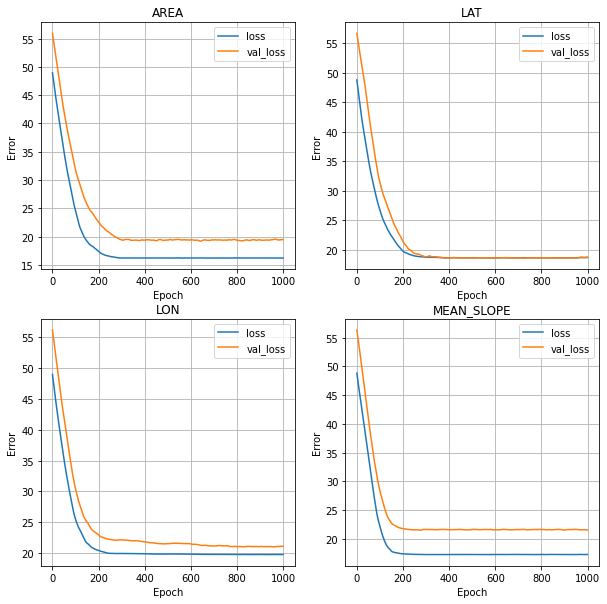

In [26]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [30]:
linear_model = build_linear_model(normalizer['ALL'])

history_full = linear_model.fit(
train_features, train_labels,        
   epochs=1000,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'MULTI': 67.22250366210938}

In [31]:
df = pd.DataFrame(history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)



           Variable       loss   val_loss
999  Multi-Variable  13.873701  19.763271


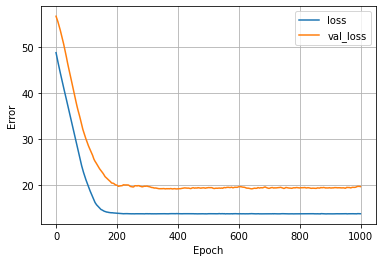

In [32]:
plot_loss(history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [33]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [34]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [35]:
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1000,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

{'AREA': 65.57528686523438,
 'LAT': 26.82623291015625,
 'LON': 28.578691482543945,
 'MEAN_SLOPE': 20.229509353637695}

In [36]:
for variable_name in variable_list:    
    df = pd.DataFrame(dnn_history[variable_name].history)
    dfs = df.loc[[df.last_valid_index()]]
    dfs.insert(0, 'Variable', [variable_name])
    
    print(dfs)
    print("")


    Variable       loss   val_loss
999     AREA  11.294652  14.570792

    Variable       loss   val_loss
999      LAT  17.401567  16.100311

    Variable       loss   val_loss
999      LON  18.489998  25.029171

       Variable       loss   val_loss
999  MEAN_SLOPE  15.809601  16.459635



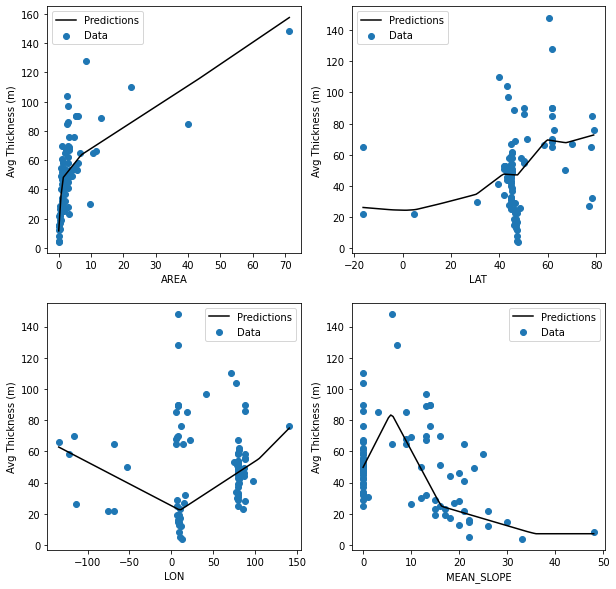

In [37]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

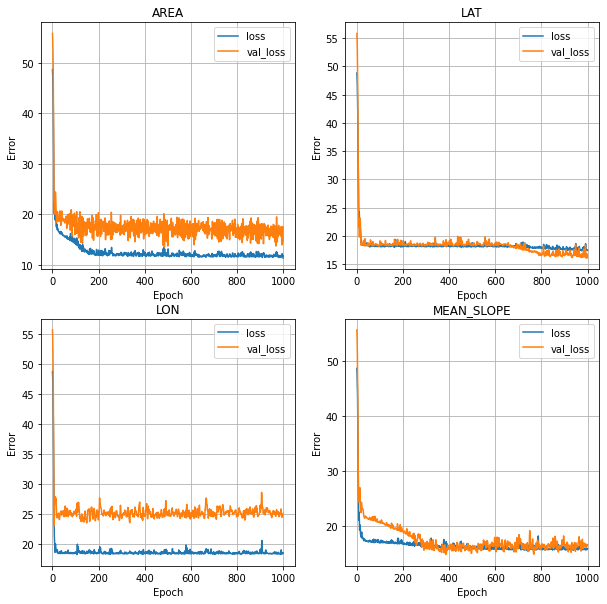

In [38]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [39]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [40]:
%%time
dnn_history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 31.7 s, sys: 6.4 s, total: 38.1 s
Wall time: 12.4 s


In [41]:
df = pd.DataFrame(dnn_history_full.history)
dfs = df.loc[[df.last_valid_index()]]
dfs.insert(0, 'Variable', 'Multi-Variable')
    
print(dfs)


           Variable      loss   val_loss
999  Multi-Variable  6.756426  11.984516


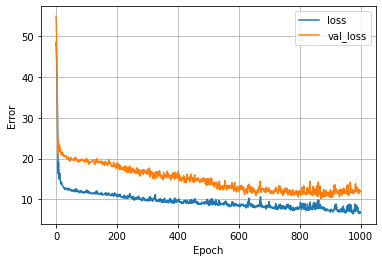

In [42]:
plot_loss(dnn_history_full)
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 120.0)

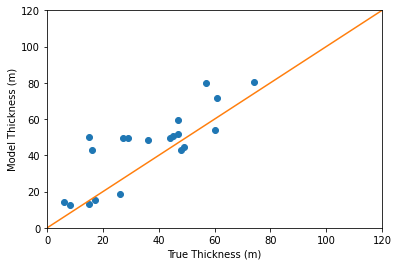

In [43]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,"o")
plt.plot((0,120),(0,120),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,120))
plt.ylim((0,120))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

In [44]:
normalizer['ALL'].adapt(np.array(RGI))
y_alaska = dnn_full_model.predict(RGI)
print(y_alaska)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
RGI["Prethicktion"] = y_alaska

RGI

In [ ]:
normalizer['ALL'].adapt(np.array(RGI))
y_alaska = dnn_full_model.predict(RGI)
print(y_alaska)

In [ ]:
RGI["thickness_prethicktions"] = y_alaska
RGI.index[RGI["thickness_prethicktions"]<0]

In [ ]:
RGI["volume"] = RGI["AREA"] * (RGI["thickness_prethicktions"]/1000)
RGI["volume"].astype(float).sum()

In [ ]:
#establish normalization layers
alaska_normalizer = {}
variable_list = ("LON",
                 "LAT",
                 "AREA",
                 "MEAN_SLOPE")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
y_alaska = dnn_full_model.predict(RGI)

print(y_alaska)

In [ ]:
# dataset_saved_for_later


# dataset_saved_for_later = dataset_saved_for_later.drop("GLACIER_ID", axis=1)
# dataset_saved_for_later = dataset_saved_for_later.drop("GlaThiDa_ID", axis=1)
# #drop the remaining null pieces from elevation
# dataset_saved_for_later = dataset_saved_for_later.dropna()
# dataset_saved_for_later.isna().sum()
dataset_saved_for_later

In [ ]:
test_features

In [ ]:
y_alaska_test = dnn_full_model.predict(RGI)

In [ ]:
plt.plot(y_alaska_test,".")
# plt.plot((0,1000),(0,1000),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((-10,3000))
plt.ylim((-200,300))

In [ ]:
print(y_alaska_test)